# Setup

In [ ]:
import pandas as pd
import scipy
import copy
import numpy as np
import plotly.express as px
import matplotlib.pyplot as plt
import plotly.express as px

from scipy import stats

from sklearn.model_selection import train_test_split

In [ ]:
def generate_gaussian(rho, sample_size=2000):
  mean = np.zeros(2)
  E = np.zeros(shape=(2, 2)) + rho
  E[0, 0] = 1
  E[1, 1] =1

  D = np.random.multivariate_normal(mean=mean, cov=E, size=(sample_size, )).T

  # Generating Train and test data
  shuf_indexes = np.random.permutation(sample_size)

  train_p = 0.75
  n_train = int(D.shape[1] * train_p)
  n_test = D.shape[1] - n_train

  train_D = D[:, shuf_indexes[:n_train]]
  test_D = D[:, shuf_indexes[n_train:]]

  return train_D, test_D


def GT_gaussian_density(points, rho):
  x = points[0]
  y = points[1]

  c_uv = (1/np.sqrt(1 - rho**2)) * np.exp( ((-1 * rho**2 * x**2 * y**2) - (2*rho*x*y)) / (2*(1 - rho**2)) )
  f_x = stats.norm.pdf(x)
  f_y = stats.norm.pdf(y)

  return c_uv * f_x * f_y

In [ ]:
# Marshal and Olkin
def clayton_sample(theta):
  alpha = 1 / theta
  beta = 1
  V = np.random.gamma(shape=alpha, scale=beta)
  R = np.random.exponential(scale=1, size=2)
  t = R / V
  U = (1 + t) ** (-1/theta)
  return U

# Generate Clayton Copula with N(0,1) margins
def generate_clayton_sample(theta, sample_size=2000):
  X = []
  Y = []
  for _ in range(sample_size):
    U = clayton_sample(theta)
    X.append(stats.norm.ppf(U[0]))
    Y.append(stats.norm.ppf(U[1]))

  D = np.concatenate((X, Y)).reshape((2, -1))

  # Generating Train and test data
  shuf_indexes = np.random.permutation(sample_size)

  train_p = 0.75
  n_train = int(D.shape[1] * train_p)
  n_test = D.shape[1] - n_train

  train_D = D[:, shuf_indexes[:n_train]]
  test_D = D[:, shuf_indexes[n_train:]]

  return train_D, test_D

In [ ]:
# Marshal and Olkin
def frank_sample(theta):
  p = 1 - np.exp(-theta)
  V = stats.logser.rvs(p)
  R = np.random.exponential(scale=1, size=2)
  t = R / V
  U = -1/theta * np.log( 1 - ( (1 - np.exp(-theta)) * (np.exp(-t)) ) )
  return U

# Generate Frank Copula with N(0,1) margins
def generate_frank_sample(theta, sample_size=2000):
  X = []
  Y = []
  for _ in range(sample_size):
    U = frank_sample(theta)
    X.append(stats.norm.ppf(U[0]))
    Y.append(stats.norm.ppf(U[1]))

  D = np.concatenate((X, Y)).reshape((2, -1))

  # Generating Train and test data
  shuf_indexes = np.random.permutation(sample_size)

  train_p = 0.75
  n_train = int(D.shape[1] * train_p)
  n_test = D.shape[1] - n_train

  train_D = D[:, shuf_indexes[:n_train]]
  test_D = D[:, shuf_indexes[n_train:]]

  return train_D, test_D

In [ ]:
def visualize_data(D):
  _, ax = plt.subplots(figsize=(5.5, 5))

  ax.scatter(
      D[0],
      D[1],
      s=80,
      edgecolor='k',
      alpha=0.5
  )

  plt.show()

# Neural Likelihoods

## imports

In [ ]:
!git clone https://github.com/pawelc/NeuralLikelihoods.git chilinski2020neural
%cd chilinski2020neural

Cloning into 'chilinski2020neural'...
remote: Enumerating objects: 468, done.
remote: Counting objects: 100% (468/468), done.
remote: Compressing objects: 100% (225/225), done.
remote: Total 468 (delta 264), reused 398 (delta 195), pack-reused 0
Receiving objects: 100% (468/468), 11.85 MiB | 9.50 MiB/s, done.
Resolving deltas: 100% (264/264), done.
/content/chilinski2020neural


In [ ]:
import sys
sys.path.append('code')

In [ ]:
# from sklearn.preprocessing import MinMaxScaler
# scaler = MinMaxScaler()

In [ ]:
%load_ext autoreload
%autoreload 2

import os
import json
from functools import reduce
import numpy as np

from conf import conf

import tensorflow as tf
tfk = tf.keras
import tensorflow_probability as tfp
tfd = tfp.distributions
import tensorflow_datasets as tfds
K = tfk.backend

import plotly.graph_objs as go
import plotly.express as px
from plotly.offline import iplot

from models.tensorflow.rnade import Rnade
from models.tensorflow.rnade_deep import RnadeDeep
from models.tensorflow.maf import MAF
from models.tensorflow.mdn import MDN
from models.tensorflow.monde import MONDE
from models.tensorflow.monde_ar_made import MondeARMADE
from data import registry
from models.tensorflow.compute import get_device
from utils import elapsed_timer
import utils as nl_utils

In [ ]:
from scipy.stats import bootstrap

In [ ]:
def loss_fn(_, log_prob):
    return -tf.reduce_mean(log_prob)

In [ ]:
''' # n_data = 10000
batch_size = 128
#max_epochs = 10000
os.environ['CUDA_VISIBLE_DEVICES'] = '0'
# device = get_device()
logical_gpus = tf.config.experimental.list_logical_devices('GPU')
device = logical_gpus[0].name


K.clear_session()
with tf.device(device):
#     model = Rnade(k_mix = 10, hidden_units=128, component_distribution="normal")
#     model = Rnade(k_mix = 10, hidden_units=128, component_distribution="laplace")
#     model = RnadeDeep(k_mix = 10, arch=[64,64], component_distribution="normal") # 6,366
#     model = RnadeDeep(k_mix = 10, arch=[64,64], component_distribution="laplace") # 6,366
#     model = MAF(num_bijectors=2, hidden_units=[32,32], covariate_hidden_units=[16,16], batch_norm=False) #5,188
#     model = MDN(arch=[64,64], num_mixtures=10) # 6,238
#     model = MONDE(cov_type="const_cov", arch_hxy=[64,64], arch_x_transform=[64,64], arch_cov_transform=None, hxy_x_size=32, covariance_learning_rate=None)
    model = MondeARMADE(arch = [32, 32], transform = 'sigm', x_transform_size = 16) # 2,241
    model.build([[None, 1], [None, 1]])


model.compile(optimizer = tfk.optimizers.Adam(), loss = loss_fn)
os.makedirs('test', exist_ok = True) '''

' # n_data = 10000\nbatch_size = 128\n#max_epochs = 10000\nos.environ[\'CUDA_VISIBLE_DEVICES\'] = \'0\'\n# device = get_device()\nlogical_gpus = tf.config.experimental.list_logical_devices(\'GPU\')\ndevice = logical_gpus[0].name\n\n\nK.clear_session()\nwith tf.device(device):\n#     model = Rnade(k_mix = 10, hidden_units=128, component_distribution="normal")\n#     model = Rnade(k_mix = 10, hidden_units=128, component_distribution="laplace")\n#     model = RnadeDeep(k_mix = 10, arch=[64,64], component_distribution="normal") # 6,366\n#     model = RnadeDeep(k_mix = 10, arch=[64,64], component_distribution="laplace") # 6,366\n#     model = MAF(num_bijectors=2, hidden_units=[32,32], covariate_hidden_units=[16,16], batch_norm=False) #5,188\n#     model = MDN(arch=[64,64], num_mixtures=10) # 6,238\n#     model = MONDE(cov_type="const_cov", arch_hxy=[64,64], arch_x_transform=[64,64], arch_cov_transform=None, hxy_x_size=32, covariance_learning_rate=None)\n    model = MondeARMADE(arch = [32, 3

In [ ]:
def run_NL(train_D, test_D, dataset, max_epochs=10000):
    train_y = train_D[1].reshape(-1, 1)
    train_x = train_D[0].reshape(-1, 1)

    validation_y = test_D[1].reshape(-1, 1)
    validation_x = test_D[0].reshape(-1, 1)

    # n_data = 10000
    batch_size = 128
    #max_epochs = 10000
    os.environ['CUDA_VISIBLE_DEVICES'] = '0'
    # device = get_device()
    logical_gpus = tf.config.experimental.list_logical_devices('GPU')
    device = logical_gpus[0].name


    train_dataset = tf.data.Dataset.from_tensor_slices(
            ((train_y, train_x), np.zeros((len(train_y), 0), dtype=np.float32)))
    train_dataset = train_dataset.repeat(None)
    train_dataset = train_dataset.shuffle(buffer_size=len(train_y))
    train_dataset = train_dataset.prefetch(3 * batch_size)
    train_dataset = train_dataset.batch(batch_size)

    val_dataset = tf.data.Dataset.from_tensor_slices(
            ((validation_y, validation_x), np.zeros((len(validation_y), 0), dtype=np.float32)))
    val_dataset = val_dataset.repeat(1)
    val_dataset = val_dataset.prefetch(len(validation_y))
    val_dataset = val_dataset.batch(len(validation_y))


    K.clear_session()
    with tf.device(device):
        model = MondeARMADE(arch = [32, 32], transform = 'sigm', x_transform_size = 16) # 2,241
        model.build([[None, 1], [None, 1]])

    model.compile(optimizer = tfk.optimizers.Adam(), loss = loss_fn)
    os.makedirs('test', exist_ok = True)


    file_name = 'test/{}_{}'.format(model.model_name, dataset)

    model.save_to_json('{}.json'.format(file_name))


    callbacks = []
    callbacks.append(tfk.callbacks.TerminateOnNaN())
    callbacks.append(tfk.callbacks.ModelCheckpoint('{}.h5'.format(file_name),
                                                  monitor = 'val_loss', mode = 'min', verbose = 0, save_best_only = True, save_weights_only = True))
    callbacks.append(tfk.callbacks.History())
    # callbacks.append(tfk.callbacks.EarlyStopping(monitor = 'loss', patience = 30))

    steps_per_epoch = int(np.ceil(len(train_y) / batch_size))
    with elapsed_timer("training"):
        history = model.fit(x = train_dataset, validation_data = val_dataset, verbose = 1, epochs = max_epochs, steps_per_epoch = steps_per_epoch, callbacks = callbacks)

    # true_avg_ll = -np.mean(data_loader.ll(data_loader.validation_data))
    fig = go.Figure()
    fig.add_trace(go.Scatter(x = history.epoch, y = history.history['loss'], name = "train -ll"))
    fig.add_trace(go.Scatter(x = history.epoch, y = history.history['val_loss'], name = "validation -ll"))
    # fig.add_shape(go.layout.Shape(type = "line", xref = "paper", x0 = 0, y0 = true_avg_ll, x1 = 1, name = "true ll", y1 = true_avg_ll,
    #                               line = dict(color = "LightSeaGreen", width = 4,dash = "dashdot")))
    fig.update_layout(showlegend = True)
    iplot(fig);

    with tf.device(device):
        model = nl_utils.load_model_and_params(file_name)
    return model


## Gauss $\rho = 0.1$

In [ ]:
np.random.seed(30091985)

In [ ]:
rho = 0.1
train_D, test_D = generate_gaussian(rho)
# train_D = scaler.fit_transform(train_D.T).T
# test_D = scaler.fit_transform(test_D.T).T

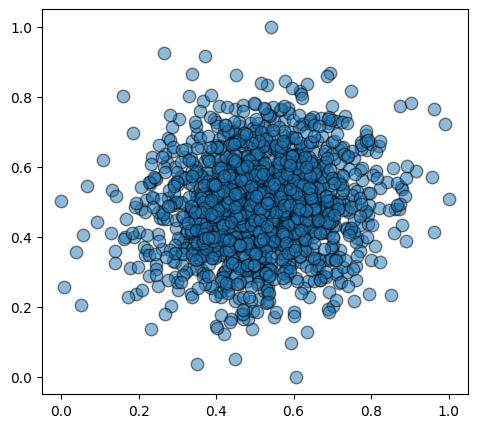

In [ ]:
visualize_data(train_D)

In [ ]:
model = run_NL(train_D, test_D,'gauss_01', max_epochs=3000)

A saída de streaming foi truncada nas últimas 5000 linhas.
12/12 [==============================] - 0s 7ms/step - loss: -0.5681 - val_loss: -0.3305
Epoch 502/3000
12/12 [==============================] - 0s 7ms/step - loss: -0.5540 - val_loss: -0.3078
Epoch 503/3000
12/12 [==============================] - 0s 7ms/step - loss: -0.5828 - val_loss: -0.3121
Epoch 504/3000
12/12 [==============================] - 0s 8ms/step - loss: -0.5530 - val_loss: -0.3073
Epoch 505/3000
12/12 [==============================] - 0s 7ms/step - loss: -0.5547 - val_loss: -0.3193
Epoch 506/3000
12/12 [==============================] - 0s 7ms/step - loss: -0.5539 - val_loss: -0.3211
Epoch 507/3000
12/12 [==============================] - 0s 8ms/step - loss: -0.5768 - val_loss: -0.3126
Epoch 508/3000
12/12 [==============================] - 0s 7ms/step - loss: -0.5473 - val_loss: -0.3208
Epoch 509/3000
12/12 [==============================] - 0s 8ms/step - loss: -0.5533 - val_loss: -0.3225
Epoch 510/3000
12/12

In [ ]:
validation_y = test_D[1].reshape(-1, 1)
validation_x = test_D[0].reshape(-1, 1)

prob = model.prob(tf.convert_to_tensor(validation_y, dtype = float), tf.convert_to_tensor(validation_x, dtype = float), training = False).numpy()
np.mean(-np.log(prob))

-0.33549085

In [ ]:
yhat = -np.log(prob)
nll = np.mean(yhat)
res = bootstrap((yhat,), np.mean)
rmean = res.bootstrap_distribution.mean()
low = res.confidence_interval.low
high = res.confidence_interval.high
dev1 = high - rmean
dev2 = rmean - low
dev = dev1 if dev1 > dev2 else dev2

print(f'NLL: {nll:.4f} RMean: {rmean:.4f} IC: ({low[0]:.4f},{high[0]:.4f}) Notation: {rmean:.2f}$\pm${dev[0]:.2f}')

NLL: -0.3355 RMean: -0.3354 IC: (-0.4168,-0.2417) Notation: -0.34$\pm$0.09


## Gauss $\rho = 0.5$

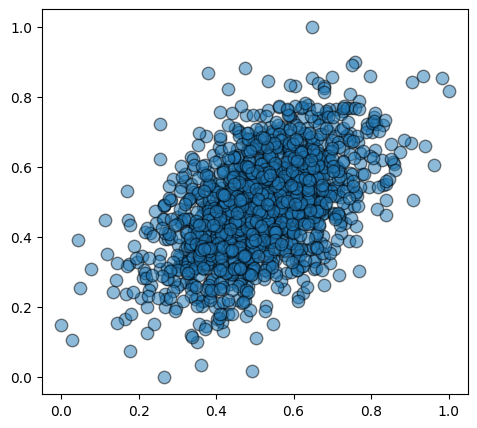

In [ ]:
np.random.seed(30091985)

rho = 0.5
train_D, test_D = generate_gaussian(rho)
# train_D = scaler.fit_transform(train_D.T).T
# test_D = scaler.fit_transform(test_D.T).T

visualize_data(train_D)

In [ ]:
model = run_NL(train_D, test_D, 'gauss_05', max_epochs=3000)

A saída de streaming foi truncada nas últimas 5000 linhas.
12/12 [==============================] - 0s 9ms/step - loss: -0.6707 - val_loss: -0.4138
Epoch 502/3000
12/12 [==============================] - 0s 9ms/step - loss: -0.6492 - val_loss: -0.4134
Epoch 503/3000
12/12 [==============================] - 0s 9ms/step - loss: -0.6503 - val_loss: -0.4171
Epoch 504/3000
12/12 [==============================] - 0s 10ms/step - loss: -0.6857 - val_loss: -0.4126
Epoch 505/3000
12/12 [==============================] - 0s 10ms/step - loss: -0.6632 - val_loss: -0.4066
Epoch 506/3000
12/12 [==============================] - 0s 8ms/step - loss: -0.6487 - val_loss: -0.4182
Epoch 507/3000
12/12 [==============================] - 0s 9ms/step - loss: -0.6700 - val_loss: -0.3947
Epoch 508/3000
12/12 [==============================] - 0s 10ms/step - loss: -0.6755 - val_loss: -0.4171
Epoch 509/3000
12/12 [==============================] - 0s 9ms/step - loss: -0.6490 - val_loss: -0.4086
Epoch 510/3000
12

In [ ]:
validation_y = test_D[1].reshape(-1, 1)
validation_x = test_D[0].reshape(-1, 1)

prob = model.prob(tf.convert_to_tensor(validation_y, dtype = float), tf.convert_to_tensor(validation_x, dtype = float), training = False).numpy()
np.mean(-np.log(prob))

-0.4329294

In [ ]:
yhat = -np.log(prob)
nll = np.mean(yhat)
res = bootstrap((yhat,), np.mean)
rmean = res.bootstrap_distribution.mean()
low = res.confidence_interval.low
high = res.confidence_interval.high
dev1 = high - rmean
dev2 = rmean - low
dev = dev1 if dev1 > dev2 else dev2

print(f'NLL: {nll:.4f} RMean: {rmean:.4f} IC: ({low[0]:.4f},{high[0]:.4f}) Notation: {rmean:.2f}$\pm${dev[0]:.2f}')

NLL: -0.4329 RMean: -0.4328 IC: (-0.4967,-0.3611) Notation: -0.43$\pm$0.07


## Gauss $\rho = 0.9$

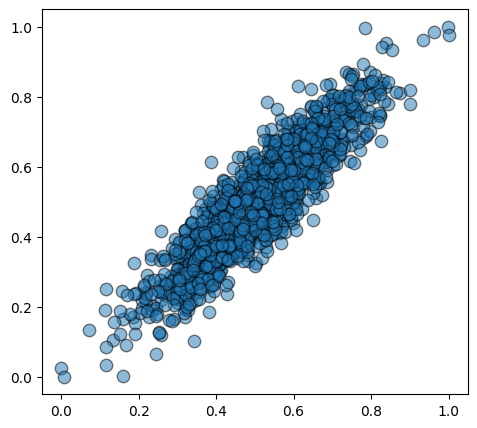

In [ ]:
np.random.seed(30091985)

rho = 0.9
train_D, test_D = generate_gaussian(rho)
# train_D = scaler.fit_transform(train_D.T).T
# test_D = scaler.fit_transform(test_D.T).T

visualize_data(train_D)

In [ ]:
model2 = run_NL(train_D, test_D, 'gauss_09', max_epochs=3000)

A saída de streaming foi truncada nas últimas 5000 linhas.
12/12 [==============================] - 0s 9ms/step - loss: -1.2743 - val_loss: -1.0404
Epoch 502/3000
12/12 [==============================] - 0s 9ms/step - loss: -1.2638 - val_loss: -1.0459
Epoch 503/3000
12/12 [==============================] - 0s 11ms/step - loss: -1.2396 - val_loss: -1.0173
Epoch 504/3000
12/12 [==============================] - 0s 9ms/step - loss: -1.2878 - val_loss: -1.0591
Epoch 505/3000
12/12 [==============================] - 0s 9ms/step - loss: -1.2549 - val_loss: -1.0495
Epoch 506/3000
12/12 [==============================] - 0s 10ms/step - loss: -1.2763 - val_loss: -1.0302
Epoch 507/3000
12/12 [==============================] - 0s 9ms/step - loss: -1.2490 - val_loss: -1.0352
Epoch 508/3000
12/12 [==============================] - 0s 10ms/step - loss: -1.2672 - val_loss: -1.0621
Epoch 509/3000
12/12 [==============================] - 0s 9ms/step - loss: -1.2617 - val_loss: -1.0376
Epoch 510/3000
12

In [ ]:
validation_y = test_D[1].reshape(-1, 1)
validation_x = test_D[0].reshape(-1, 1)

prob = model2.prob(tf.convert_to_tensor(validation_y, dtype = float), tf.convert_to_tensor(validation_x, dtype = float), training = False).numpy()
np.mean(-np.log(prob))

-1.074203

In [ ]:
yhat = -np.log(prob)
nll = np.mean(yhat)
res = bootstrap((yhat,), np.mean)
rmean = res.bootstrap_distribution.mean()
low = res.confidence_interval.low
high = res.confidence_interval.high
dev1 = high - rmean
dev2 = rmean - low
dev = dev1 if dev1 > dev2 else dev2

print(f'NLL: {nll:.4f} RMean: {rmean:.4f} IC: ({low[0]:.4f},{high[0]:.4f}) Notation: {rmean:.2f}$\pm${dev[0]:.2f}')

NLL: -1.0742 RMean: -1.0743 IC: (-1.1388,-1.0015) Notation: -1.07$\pm$0.07


## Clayton $\theta = 1$

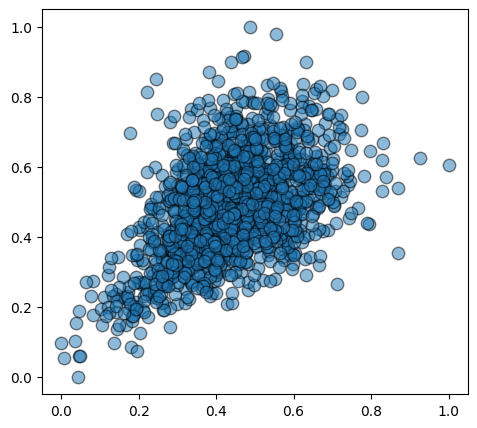

In [ ]:
np.random.seed(30091985)

theta = 1
train_D, test_D = generate_clayton_sample(theta)
# train_D = scaler.fit_transform(train_D.T).T
# test_D = scaler.fit_transform(test_D.T).T

visualize_data(train_D)

In [ ]:
model = run_NL(train_D, test_D, 'clayton_1', max_epochs=3000)

A saída de streaming foi truncada nas últimas 5000 linhas.
12/12 [==============================] - 0s 8ms/step - loss: -0.6726 - val_loss: -0.6007
Epoch 502/3000
12/12 [==============================] - 0s 10ms/step - loss: -0.6571 - val_loss: -0.5624
Epoch 503/3000
12/12 [==============================] - 0s 8ms/step - loss: -0.6601 - val_loss: -0.5926
Epoch 504/3000
12/12 [==============================] - 0s 7ms/step - loss: -0.6666 - val_loss: -0.5933
Epoch 505/3000
12/12 [==============================] - 0s 7ms/step - loss: -0.6731 - val_loss: -0.5731
Epoch 506/3000
12/12 [==============================] - 0s 8ms/step - loss: -0.6727 - val_loss: -0.5951
Epoch 507/3000
12/12 [==============================] - 0s 9ms/step - loss: -0.6474 - val_loss: -0.5842
Epoch 508/3000
12/12 [==============================] - 0s 9ms/step - loss: -0.6549 - val_loss: -0.5816
Epoch 509/3000
12/12 [==============================] - 0s 8ms/step - loss: -0.6534 - val_loss: -0.5793
Epoch 510/3000
12/1

In [ ]:
validation_y = test_D[1].reshape(-1, 1)
validation_x = test_D[0].reshape(-1, 1)

prob = model.prob(tf.convert_to_tensor(validation_y, dtype = float), tf.convert_to_tensor(validation_x, dtype = float), training = False).numpy()
np.mean(-np.log(prob))

-0.63669014

In [ ]:
yhat = -np.log(prob)
nll = np.mean(yhat)
res = bootstrap((yhat,), np.mean)
rmean = res.bootstrap_distribution.mean()
low = res.confidence_interval.low
high = res.confidence_interval.high
dev1 = high - rmean
dev2 = rmean - low
dev = dev1 if dev1 > dev2 else dev2

print(f'NLL: {nll:.4f} RMean: {rmean:.4f} IC: ({low[0]:.4f},{high[0]:.4f}) Notation: {rmean:.2f}$\pm${dev[0]:.2f}')

NLL: -0.6367 RMean: -0.6364 IC: (-0.6972,-0.5680) Notation: -0.64$\pm$0.07


## Clayton $\theta = 5$

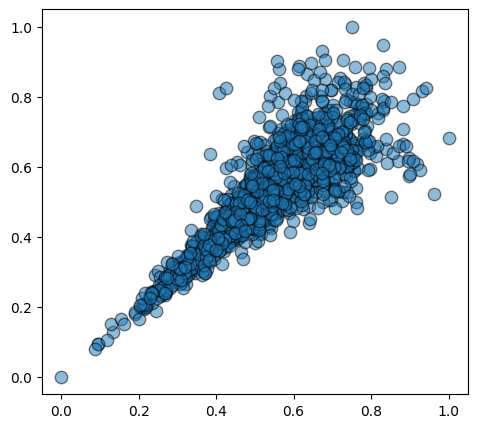

In [ ]:
np.random.seed(30091985)

theta = 5
train_D, test_D = generate_clayton_sample(theta)
# train_D = scaler.fit_transform(train_D.T).T
# test_D = scaler.fit_transform(test_D.T).T

visualize_data(train_D)

In [ ]:
model = run_NL(train_D, test_D, 'clayton_5', max_epochs=3000)

A saída de streaming foi truncada nas últimas 5000 linhas.
12/12 [==============================] - 0s 7ms/step - loss: -1.2821 - val_loss: -0.9925
Epoch 502/3000
12/12 [==============================] - 0s 6ms/step - loss: -1.3034 - val_loss: -1.0109
Epoch 503/3000
12/12 [==============================] - 0s 7ms/step - loss: -1.3073 - val_loss: -1.0241
Epoch 504/3000
12/12 [==============================] - 0s 8ms/step - loss: -1.3158 - val_loss: -1.0073
Epoch 505/3000
12/12 [==============================] - 0s 7ms/step - loss: -1.3006 - val_loss: -1.0462
Epoch 506/3000
12/12 [==============================] - 0s 7ms/step - loss: -1.3045 - val_loss: -0.9854
Epoch 507/3000
12/12 [==============================] - 0s 7ms/step - loss: -1.2823 - val_loss: -1.0443
Epoch 508/3000
12/12 [==============================] - 0s 7ms/step - loss: -1.3470 - val_loss: -1.0484
Epoch 509/3000
12/12 [==============================] - 0s 7ms/step - loss: -1.3203 - val_loss: -1.0278
Epoch 510/3000
12/12

In [ ]:
validation_y = test_D[1].reshape(-1, 1)
validation_x = test_D[0].reshape(-1, 1)

prob = model.prob(tf.convert_to_tensor(validation_y, dtype = float), tf.convert_to_tensor(validation_x, dtype = float), training = False).numpy()
np.mean(-np.log(prob))

-1.1719182

In [ ]:
yhat = -np.log(prob)
nll = np.mean(yhat)
res = bootstrap((yhat,), np.mean)
rmean = res.bootstrap_distribution.mean()
low = res.confidence_interval.low
high = res.confidence_interval.high
dev1 = high - rmean
dev2 = rmean - low
dev = dev1 if dev1 > dev2 else dev2

print(f'NLL: {nll:.4f} RMean: {rmean:.4f} IC: ({low[0]:.4f},{high[0]:.4f}) Notation: {rmean:.2f}$\pm${dev[0]:.2f}')

NLL: -1.1719 RMean: -1.1728 IC: (-1.2784,-1.0438) Notation: -1.17$\pm$0.13


## Clayton $\theta = 10$

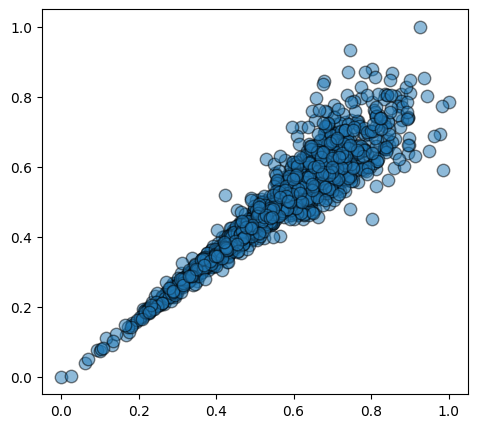

In [ ]:
np.random.seed(30091985)

theta = 10
train_D, test_D = generate_clayton_sample(theta)
# train_D = scaler.fit_transform(train_D.T).T
# test_D = scaler.fit_transform(test_D.T).T

visualize_data(train_D)

In [ ]:
model = run_NL(train_D, test_D, 'clayton_10', max_epochs=3000)

A saída de streaming foi truncada nas últimas 5000 linhas.
12/12 [==============================] - 0s 11ms/step - loss: -1.8724 - val_loss: -0.3986
Epoch 502/3000
12/12 [==============================] - 0s 9ms/step - loss: -1.8622 - val_loss: -0.4146
Epoch 503/3000
12/12 [==============================] - 0s 10ms/step - loss: -1.8593 - val_loss: -0.5261
Epoch 504/3000
12/12 [==============================] - 0s 13ms/step - loss: -1.8498 - val_loss: -0.4078
Epoch 505/3000
12/12 [==============================] - 0s 10ms/step - loss: -1.8775 - val_loss: -0.5791
Epoch 506/3000
12/12 [==============================] - 0s 10ms/step - loss: -1.8799 - val_loss: -0.4720
Epoch 507/3000
12/12 [==============================] - 0s 10ms/step - loss: -1.8872 - val_loss: -0.5105
Epoch 508/3000
12/12 [==============================] - 0s 10ms/step - loss: -1.8869 - val_loss: -0.3561
Epoch 509/3000
12/12 [==============================] - 0s 10ms/step - loss: -1.8477 - val_loss: -0.4355
Epoch 510/30

In [ ]:
validation_y = test_D[1].reshape(-1, 1)
validation_x = test_D[0].reshape(-1, 1)

prob = model.prob(tf.convert_to_tensor(validation_y, dtype = float), tf.convert_to_tensor(validation_x, dtype = float), training = False).numpy()
np.mean(-np.log(prob))

-1.0344055

In [ ]:
yhat = -np.log(prob)
nll = np.mean(yhat)
res = bootstrap((yhat,), np.mean)
rmean = res.bootstrap_distribution.mean()
low = res.confidence_interval.low
high = res.confidence_interval.high
dev1 = high - rmean
dev2 = rmean - low
dev = dev1 if dev1 > dev2 else dev2

print(f'NLL: {nll:.4f} RMean: {rmean:.4f} IC: ({low[0]:.4f},{high[0]:.4f}) Notation: {rmean:.2f}$\pm${dev[0]:.2f}')

NLL: -1.0344 RMean: -1.0343 IC: (-1.0942,-0.9611) Notation: -1.03$\pm$0.07


## Frank $\theta = 1$

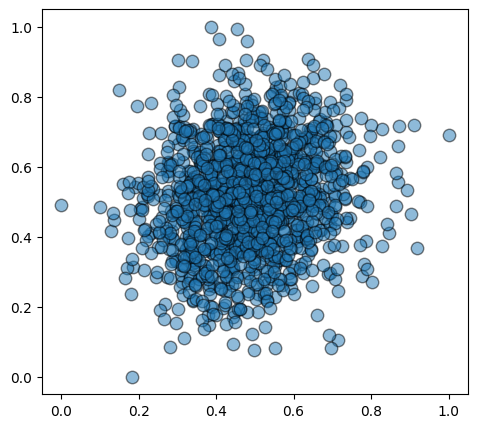

In [ ]:
np.random.seed(30091985)

theta = 1
train_D, test_D = generate_frank_sample(theta)
# train_D = scaler.fit_transform(train_D.T).T
# test_D = scaler.fit_transform(test_D.T).T

visualize_data(train_D)

In [ ]:
model2 = run_NL(train_D, test_D, 'frank_1', max_epochs=3000)

A saída de streaming foi truncada nas últimas 5000 linhas.
12/12 [==============================] - 0s 9ms/step - loss: -0.4642 - val_loss: -0.4142
Epoch 502/3000
12/12 [==============================] - 0s 11ms/step - loss: -0.4783 - val_loss: -0.4128
Epoch 503/3000
12/12 [==============================] - 0s 9ms/step - loss: -0.4652 - val_loss: -0.4144
Epoch 504/3000
12/12 [==============================] - 0s 10ms/step - loss: -0.4636 - val_loss: -0.4102
Epoch 505/3000
12/12 [==============================] - 0s 9ms/step - loss: -0.4621 - val_loss: -0.4143
Epoch 506/3000
12/12 [==============================] - 0s 10ms/step - loss: -0.4638 - val_loss: -0.4139
Epoch 507/3000
12/12 [==============================] - 0s 10ms/step - loss: -0.4829 - val_loss: -0.4124
Epoch 508/3000
12/12 [==============================] - 0s 11ms/step - loss: -0.4664 - val_loss: -0.4133
Epoch 509/3000
12/12 [==============================] - 0s 10ms/step - loss: -0.4637 - val_loss: -0.4122
Epoch 510/3000

In [ ]:
validation_y = test_D[1].reshape(-1, 1)
validation_x = test_D[0].reshape(-1, 1)

prob = model2.prob(tf.convert_to_tensor(validation_y, dtype = float), tf.convert_to_tensor(validation_x, dtype = float), training = False).numpy()
np.mean(-np.log(prob))

-0.42114747

In [ ]:
yhat = -np.log(prob)
nll = np.mean(yhat)
res = bootstrap((yhat,), np.mean)
rmean = res.bootstrap_distribution.mean()
low = res.confidence_interval.low
high = res.confidence_interval.high
dev1 = high - rmean
dev2 = rmean - low
dev = dev1 if dev1 > dev2 else dev2

print(f'NLL: {nll:.4f} RMean: {rmean:.4f} IC: ({low[0]:.4f},{high[0]:.4f}) Notation: {rmean:.2f}$\pm${dev[0]:.2f}')

NLL: -0.4211 RMean: -0.4212 IC: (-0.4831,-0.3491) Notation: -0.42$\pm$0.07


## Frank $\theta = 5$

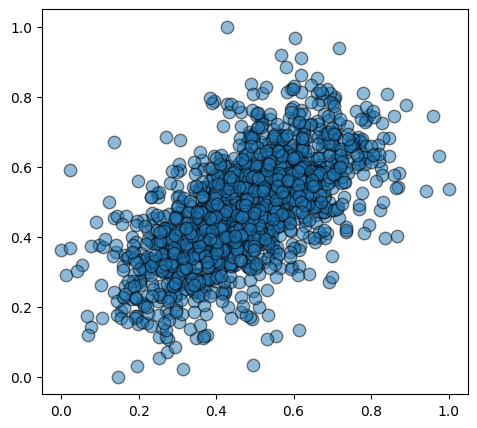

In [ ]:
np.random.seed(30091985)

theta = 5
train_D, test_D = generate_frank_sample(theta)
# train_D = scaler.fit_transform(train_D.T).T
# test_D = scaler.fit_transform(test_D.T).T

visualize_data(train_D)

In [ ]:
model2 = run_NL(train_D, test_D, 'frank_5', max_epochs=3000)

A saída de streaming foi truncada nas últimas 5000 linhas.
12/12 [==============================] - 0s 9ms/step - loss: -0.7168 - val_loss: -0.5813
Epoch 502/3000
12/12 [==============================] - 0s 9ms/step - loss: -0.7189 - val_loss: -0.5793
Epoch 503/3000
12/12 [==============================] - 0s 8ms/step - loss: -0.6993 - val_loss: -0.5769
Epoch 504/3000
12/12 [==============================] - 0s 9ms/step - loss: -0.7445 - val_loss: -0.5747
Epoch 505/3000
12/12 [==============================] - 0s 9ms/step - loss: -0.7083 - val_loss: -0.5808
Epoch 506/3000
12/12 [==============================] - 0s 9ms/step - loss: -0.6918 - val_loss: -0.5801
Epoch 507/3000
12/12 [==============================] - 0s 9ms/step - loss: -0.7017 - val_loss: -0.5777
Epoch 508/3000
12/12 [==============================] - 0s 7ms/step - loss: -0.7465 - val_loss: -0.5759
Epoch 509/3000
12/12 [==============================] - 0s 7ms/step - loss: -0.6978 - val_loss: -0.5785
Epoch 510/3000
12/12

In [ ]:
validation_y = test_D[1].reshape(-1, 1)
validation_x = test_D[0].reshape(-1, 1)

prob = model2.prob(tf.convert_to_tensor(validation_y, dtype = float), tf.convert_to_tensor(validation_x, dtype = float), training = False).numpy()
np.mean(-np.log(prob))

-0.5892461

In [ ]:
yhat = -np.log(prob)
nll = np.mean(yhat)
res = bootstrap((yhat,), np.mean)
rmean = res.bootstrap_distribution.mean()
low = res.confidence_interval.low
high = res.confidence_interval.high
dev1 = high - rmean
dev2 = rmean - low
dev = dev1 if dev1 > dev2 else dev2

print(f'NLL: {nll:.4f} RMean: {rmean:.4f} IC: ({low[0]:.4f},{high[0]:.4f}) Notation: {rmean:.2f}$\pm${dev[0]:.2f}')

NLL: -0.5892 RMean: -0.5888 IC: (-0.6675,-0.5056) Notation: -0.59$\pm$0.08


## Frank $\theta = 10$

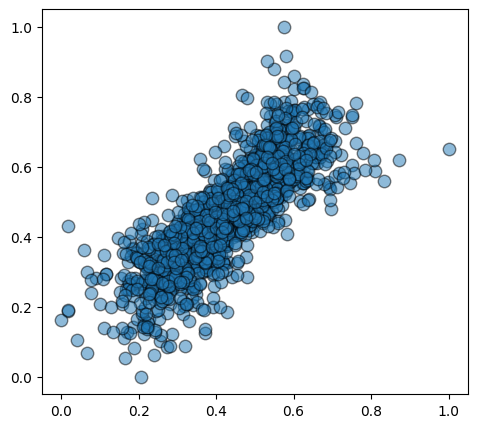

In [ ]:
np.random.seed(30091985)

theta = 10
train_D, test_D = generate_frank_sample(theta)
# train_D = scaler.fit_transform(train_D.T).T
# test_D = scaler.fit_transform(test_D.T).T

visualize_data(train_D)

In [ ]:
model2 = run_NL(train_D, test_D, 'frank_10', max_epochs=3000)

A saída de streaming foi truncada nas últimas 5000 linhas.
12/12 [==============================] - 0s 10ms/step - loss: -1.1003 - val_loss: -0.1628
Epoch 502/3000
12/12 [==============================] - 0s 11ms/step - loss: -1.0836 - val_loss: -0.1235
Epoch 503/3000
12/12 [==============================] - 0s 10ms/step - loss: -1.1024 - val_loss: -0.1896
Epoch 504/3000
12/12 [==============================] - 0s 12ms/step - loss: -1.0844 - val_loss: -0.3169
Epoch 505/3000
12/12 [==============================] - 0s 9ms/step - loss: -1.1065 - val_loss: -0.1937
Epoch 506/3000
12/12 [==============================] - 0s 9ms/step - loss: -1.0618 - val_loss: -0.1233
Epoch 507/3000
12/12 [==============================] - 0s 10ms/step - loss: -1.0716 - val_loss: -0.1903
Epoch 508/3000
12/12 [==============================] - 0s 10ms/step - loss: -1.1058 - val_loss: -0.3209
Epoch 509/3000
12/12 [==============================] - 0s 10ms/step - loss: -1.0842 - val_loss: -0.1423
Epoch 510/300

In [ ]:
validation_y = test_D[1].reshape(-1, 1)
validation_x = test_D[0].reshape(-1, 1)

prob = model2.prob(tf.convert_to_tensor(validation_y, dtype = float), tf.convert_to_tensor(validation_x, dtype = float), training = False).numpy()
np.mean(-np.log(prob))

-0.56826615

In [ ]:
yhat = -np.log(prob)
nll = np.mean(yhat)
res = bootstrap((yhat,), np.mean)
rmean = res.bootstrap_distribution.mean()
low = res.confidence_interval.low
high = res.confidence_interval.high
dev1 = high - rmean
dev2 = rmean - low
dev = dev1 if dev1 > dev2 else dev2

print(f'NLL: {nll:.4f} RMean: {rmean:.4f} IC: ({low[0]:.4f},{high[0]:.4f}) Notation: {rmean:.2f}$\pm${dev[0]:.2f}')

NLL: -0.5683 RMean: -0.5679 IC: (-0.6256,-0.5070) Notation: -0.57$\pm$0.06
